# Pipeline draft

In [ ]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

import bbrl_gymnasium

from pmind.algorithms import DQN, DDPG, TD3
from pmind.losses import dqn_compute_critic_loss, ddqn_compute_critic_loss
from pmind.training import run_dqn, run_ddpg, run_td3, run_td3_offline
from pmind.replay import get_gym_agent, get_workspace, mix_transitions, test_rb_compositions

from pmind.config.loader import load_config

bbrl_utils.setup()

%load_ext autoreload
%autoreload 2

Load all configurations:

In [ ]:
cfg = load_config("bbrl_example")

In [ ]:
setup_tensorboard("./outputs/tblogs")

## Best policy:

Get the best policy (to eventually exploit)

In [ ]:
cfg_td3_best = OmegaConf.create(cfg.td3)

# accelerate for the sake of test:
cfg_td3_best.algorithm.max_epochs = 11_000
cfg_td3_best.algorithm.learning_starts = 1000

td3 = TD3(cfg_td3_best)
run_td3(td3)
td3.visualize_best()

In [ ]:
best_policy_agent = td3.best_policy

In [ ]:
gym_agent = get_gym_agent('CartPoleContinuous-v1', num_envs=10, seed=42)
workspace_best = get_workspace(best_policy_agent ,gym_agent, epoch_size=100_000)
print(workspace_best)

## Uniform policy:

In [ ]:
class UniformAgent(Agent):
    '''Agent that explores uniformly a given environment'''

    # TODO: for now it just does a random walk,
    #   need to do jumps instead - random actions in random states
    # I think need to modify ParallelGymAgent._reset() method
    def __init__(self, env_name):
        super().__init__()
        self.env = gym.make(env_name) 

    def forward(self, t: int):
        """An Agent can use self.workspace"""
        # obs = self.get(("env/env_obs", t))
        n_env = self.workspace.batch_size()
        action = torch.tensor([self.env.action_space.sample() for _ in range(n_env) ], dtype=torch.float32)
        self.set(("action", t), action)

In [ ]:
workspace_unif = get_workspace(UniformAgent('CartPoleContinuous-v1'), gym_agent, epoch_size=100_000)
print(workspace_unif)

In [ ]:
# Poking around with the idea: may be it's easier to implement those 
# random jumps as episodes of length 2?
# for k in range(gym_agent.num_envs):
#     env = gym_agent.envs[k]
#     env.reset()
#     env.state = env.unwrapped.state = env.observation_space.sample()
# gym_agent = get_gym_agent('CartPoleContinuous-v1', num_envs=3, seed=42)
# t_agents = TemporalAgent(Agents(gym_agent,UniformAgent('CartPoleContinuous-v1')))
# workspace = Workspace()
# t_agents(workspace, t=1,n_steps=2)
# workspace_unif.get_transitions()["env/reward"]

In [792]:
from gymnasium import Wrapper

class UniformWrapper(Wrapper):
    def uniform_reset(self):
        self.reset()
        self.state = self.unwrapped.state = self.observation_space.sample()
        return self.state
    def uniform_action(self):
        return self.action_space.sample()


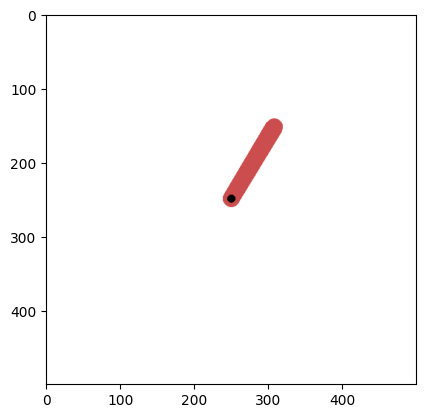

In [873]:
name = ["Pendulum-v1", "CartPoleContinuous-v1","MountainCarContinuous-v0","LunarLander-v3" ][0]
env = gym.make(name, render_mode="rgb_array")
env = UniformWrapper(env)
env.uniform_reset()
plt.imshow(env.render())

In [864]:
def get_uniform_transitions(env_name, buffer_size):
    env = UniformWrapper(gym.make(env_name))
    rb = ReplayBuffer(buffer_size)
    for _ in range(buffer_size):

        workspace = Workspace()

        state = env.uniform_reset()
        action = env.uniform_action()

        workspace.set("env/env_obs", 0, torch.tensor(state).unsqueeze(0))
        workspace.set("env/action", 0, torch.tensor(action).unsqueeze(0))

        env_response = list(env.step(action))
        
        for i in range(len(env_response)-1):
            env_response[i] = torch.tensor(env_response[i]).unsqueeze(0)
        observation, reward, terminated, truncated, _ = env_response


        workspace.set("env/env_obs", 1, observation)
        workspace.set("env/terminated", 1, terminated)
        workspace.set("env/truncated", 1, truncated)
        workspace.set("env/done", 1,  terminated or truncated)
        workspace.set("env/reward", 1,reward)
        workspace.set("env/cumulated_reward", 1,reward)
        next_action = env.action_space.sample()
        workspace.set("env/action", 1, torch.tensor(next_action).unsqueeze(0))

        rb.put(workspace.get_transitions())
    return rb

In [865]:
# TODO: doesn't work with pendulum! - find out why
name = ["Pendulum-v1", "CartPoleContinuous-v1","MountainCarContinuous-v0","LunarLander-v3" ][1]
get_uniform_transitions(name, buffer_size=100)

## Mix transitions in a buffer

In [ ]:
rb_mixed = mix_transitions(workspace_unif,
                           workspace_best,
                           buffer_size=100_000, 
                           proportion=1)

# Offline learning on mixed replay buffer

In [ ]:
cfg_td3_offline = OmegaConf.create(cfg.td3)

# accelerate for the sake of test:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000

# we don't care about when learning starts for offline:
cfg_td3_offline.algorithm.learning_starts = None

cfg_td3_offline.action_noise = 0
cfg_td3_offline.target_policy_noise = 0

td3_offline = TD3(cfg_td3_offline)
run_td3_offline(td3_offline, rb_mixed)
td3_offline.visualize_best()

In [ ]:
perfs = test_rb_compositions(workspace_unif=workspace_unif, 
                    workspace_best=workspace_best,
                    buffer_size=100_000,
                    proportions=np.linspace(0,1,10),
                    agent_constructor=TD3,
                    cfg= cfg_td3_offline,
                    offline_run=run_td3_offline)